# Task 01

### Q-Table Initialization:
 

In [ ]:
import numpy as np

def init_q_table(n_states, n_actions):
    return np.zeros((n_states, n_actions))

__it returns a 2-D array of size (number of states)*(number of actions)... intially each element of table is assigned 0 later with Q update method we try to reach the optimal policy by which our agent would behave__

### Q-Table Update Function

In [ ]:
def q_update(Q, s, a, r, s_next, alpha, gamma):
    Q[s, a] = Q[s, a] + alpha * (r + gamma * np.max(Q[s_next]) - Q[s, a])
    return Q

__As mentioned above, this is the rule for updating the Q table with subsequent episodes, gamma determines the dependence of action on future rewards__

# Task 02 ε-Greedy Policy on a Custom GridWorld


In [9]:
#installing used libraries:--
!pip install numpy matplotlib

### GridWorld Definition:

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import random

''' --------------------------------
 GridWorld Environment
 ----------------------------------'''
class GridWorld:
    def __init__(self):
        self.grid_size = 4
        self.terminal_states = {(0, 3): 1.0, (1, 3): -1.0}
        self.start_state = (3, 0)
        self.state = self.start_state

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        row, col = self.state
        if self.state in self.terminal_states:
            return self.state, 0.0, True

        # Move agent
        if action == 0 and row > 0: row -= 1        # up
        elif action == 1 and row < 3: row += 1      # down
        elif action == 2 and col > 0: col -= 1      # left
        elif action == 3 and col < 3: col += 1      # right

        self.state = (row, col)

        reward = self.terminal_states.get(self.state, -0.01)
        done = self.state in self.terminal_states
        return self.state, reward, done

    def get_state_space(self):
        return [(i, j) for i in range(self.grid_size) for j in range(self.grid_size)]

### ε-Greedy Action Selection:

In [19]:
def select_action(Q, state, epsilon):
    if random.random() < epsilon:
        return random.choice(range(4))
    else:
        return np.argmax(Q[state])

### Training and Evaluation:

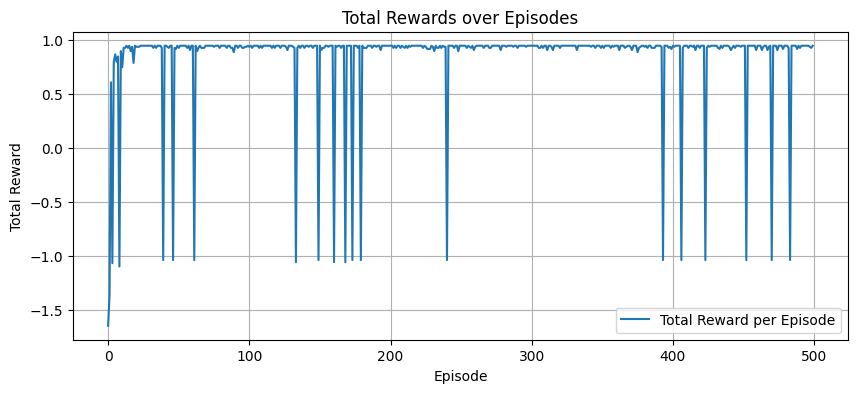

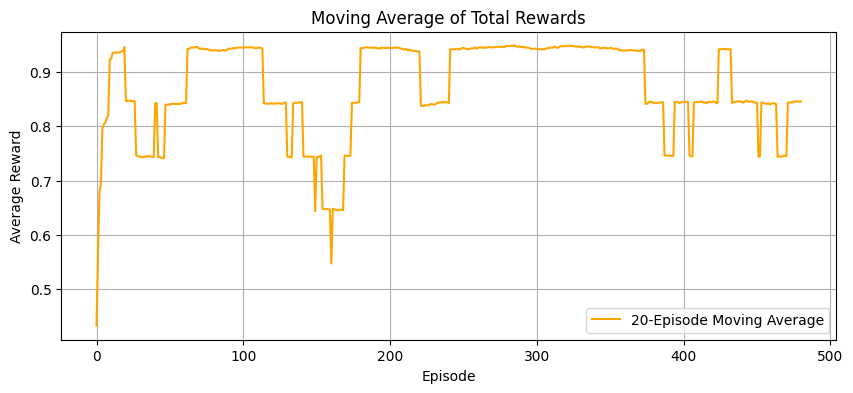

In [26]:
def train_agent(epsilon):
    env = GridWorld()
    state_space = env.get_state_space()
    state_to_idx = {s: i for i, s in enumerate(state_space)}
    Q = np.zeros((len(state_space), 4))

    episodes = 500
    alpha = 0.1
    gamma = 0.99
    total_rewards = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            s_idx = state_to_idx[state]
            action = select_action(Q, s_idx, epsilon)
            next_state, reward, done = env.step(action)
            ns_idx = state_to_idx[next_state]

            Q[s_idx, action] += alpha * (reward + gamma * np.max(Q[ns_idx]) - Q[s_idx, action])

            state = next_state
            total_reward += reward

        total_rewards.append(total_reward)

    # first plot--- toal rewards over episodes
    plt.figure(figsize=(10, 4))
    plt.plot(total_rewards, label='Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()

    # second plot-- moving average of total rewards
    window_size = 20
    moving_avg = np.convolve(total_rewards, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(10, 4))
    plt.plot(moving_avg, color='orange', label=f'{window_size}-Episode Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Moving Average of Total Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()

    return total_rewards

# Call the function to run training and see the plots
rewardss=train_agent(epsilon=0.1)


# Task 3: Experience Replay Buffer

### Replay Buffer Implementation:

In [27]:
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0 
    ####TRACKS TO THE NEXT POSITION OF INSERT

    def push(self, state, action, reward, next_state, done):
        transition = (state, action, reward, next_state, done)
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            
            self.buffer[self.position] = transition #--->OVERRIDE THE OLDEST TRANSITION WHEN BUFFER IS FULL
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        return (np.array(states),
                np.array(actions),
                np.array(rewards, dtype=np.float32),
                np.array(next_states),
                np.array(dones, dtype=np.bool_))

    def __len__(self):
        return len(self.buffer)


### Buffer Demonstration:

In [29]:
buffer = ReplayBuffer(capacity=100)

'''------------------
FILLING THE BUFFER WITH 100 RANDOM TRANSITION
---------------------'''
for _ in range(100):
    state = np.random.randint(0, 10)        # random int state
    action = np.random.randint(0, 4)        # random int action (say 4 possible actions)
    reward = np.random.uniform(-1, 1)       # random float reward between -1 and 1
    next_state = np.random.randint(0, 10)   # random int next_state
    done = random.choice([True, False])     # random done flag
    buffer.push(state, action, reward, next_state, done)

""""-------------------
SAMPLING A BATCH OF 32 TRANSITIONS FROM BUFFER
---------------------"""
states, actions, rewards, next_states, dones = buffer.sample(32)

#-------> Print shapes and types
print("States shape:", states.shape, ", dtype:", states.dtype)
print("Actions shape:", actions.shape, ", dtype:", actions.dtype)
print("Rewards shape:", rewards.shape, ", dtype:", rewards.dtype)
print("Next_states shape:", next_states.shape, ", dtype:", next_states.dtype)
print("Dones shape:", dones.shape, ", dtype:", dones.dtype)

States shape: (32,) , dtype: int64
Actions shape: (32,) , dtype: int64
Rewards shape: (32,) , dtype: float32
Next_states shape: (32,) , dtype: int64
Dones shape: (32,) , dtype: bool


# Task 4: Deep Q-Network with Target Copy

In [ ]:
#installing used libraries:--
!pip install torch

### DQN Network Architectures:


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ----------------------------------------
# DQNPolicy: Defines the policy network
# ----------------------------------------

class DQNPolicy(nn.Module):
    def __init__(self, input_dim, output_dim):

        super(DQNPolicy, self).__init__()

        # First fully connected layer (input -> 128 neurons)
        self.fc1 = nn.Linear(input_dim, 128)

        # Second fully connected layer (128 -> 128 neurons)
        self.fc2 = nn.Linear(128, 128)

        # Output layer (128 -> number of actions)
        self.out = nn.Linear(128, output_dim)

    def forward(self, x):
        """
        Forward pass for computing Q-values for each action.
        """
        x = F.relu(self.fc1(x))  # Apply ReLU activation after fc1
        x = F.relu(self.fc2(x))  # Apply ReLU activation after fc2
        return self.out(x)       # Output raw Q-values (no activation)


### DQN Target Network: Same architecture as policy network

In [32]:
class DQNTarget(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNTarget, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


### Target Network Update:

In [33]:
def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

it copies the weights from the policy network to the target network.
it helps to stabalize the training by keeping a few steps
    
Args---->
policy_net (nn.Module): The main policy network being trained.
target_net (nn.Module): The target network to be updated.

# Task 05: Full DQN Training Loop on CartPole-v1

In [ ]:
##Installing used libraries
!pip install torch numpy matplotlib gymnasium

### Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import namedtuple, deque
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

Importiing all the necessary libraries

In [2]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
       
        self.to(device)
    '''-----------------------------------------------------------------------
    ADDING THREE NN LAYERS FOR TRAINING
    ---------------------------------------------------------------------------'''
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    '''-----------------------------------------------------------------------
    
    ---------------------------------------------------------------------------'''    

   



#### Replay buffer: stores the experience tuples

In [3]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
        self.seed = random.seed(seed)
    """
    PARAMETERS:
    - action_size (int): Number of possible actions
    - buffer_size (int): Maximum size of the buffer
    - batch_size (int): Number of samples to retrieve for training
    - seed (int): Random seed for reproducibility
    
    """
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)
 

#### DQNAgent – The Deep Q-Learning Agent

In [4]:
class DQNAgent:
    # Initialize the DQN agent
    def __init__(self, state_size, action_size, seed, lr):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)


        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)#--->POLICY NETWORK
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)#---->TARGET NETWORK


        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr) #used adam optimizer as plain SGD has slower convergence
        self.memory = ReplayBuffer(action_size, buffer_size=int(1e5), batch_size=64, seed=seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory) > 64:
                experiences = self.memory.sample()
                self.learn(experiences, gamma=0.99)

    # Choose an action based on the current state
    def act(self, state, eps=0.):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state_tensor)
        self.qnetwork_local.train()

        if np.random.random() > eps:
            return action_values.argmax(dim=1).item()
        else:
            return np.random.randint(self.action_size)
        
    def update_target(self):
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())


    # Learn from batch of experiences
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences  # already unpacked tensors

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



### Training Loop: (N, M and X are hyperparameters)

Episode   2 | Avg Reward (last 100): 30.50 | Success Rate: 0.0%
Episode   4 | Avg Reward (last 100): 30.00 | Success Rate: 0.0%
Episode   6 | Avg Reward (last 100): 28.17 | Success Rate: 0.0%
Episode   8 | Avg Reward (last 100): 27.75 | Success Rate: 0.0%
Episode  10 | Avg Reward (last 100): 25.70 | Success Rate: 0.0%
Episode  12 | Avg Reward (last 100): 24.83 | Success Rate: 0.0%
Episode  14 | Avg Reward (last 100): 24.86 | Success Rate: 0.0%
Episode  16 | Avg Reward (last 100): 25.94 | Success Rate: 0.0%
Episode  18 | Avg Reward (last 100): 27.00 | Success Rate: 0.0%
Episode  20 | Avg Reward (last 100): 25.85 | Success Rate: 0.0%
Episode  22 | Avg Reward (last 100): 25.18 | Success Rate: 0.0%
Episode  24 | Avg Reward (last 100): 24.62 | Success Rate: 0.0%
Episode  26 | Avg Reward (last 100): 25.19 | Success Rate: 0.0%
Episode  28 | Avg Reward (last 100): 26.75 | Success Rate: 0.0%
Episode  30 | Avg Reward (last 100): 26.83 | Success Rate: 0.0%
Episode  32 | Avg Reward (last 100): 26.

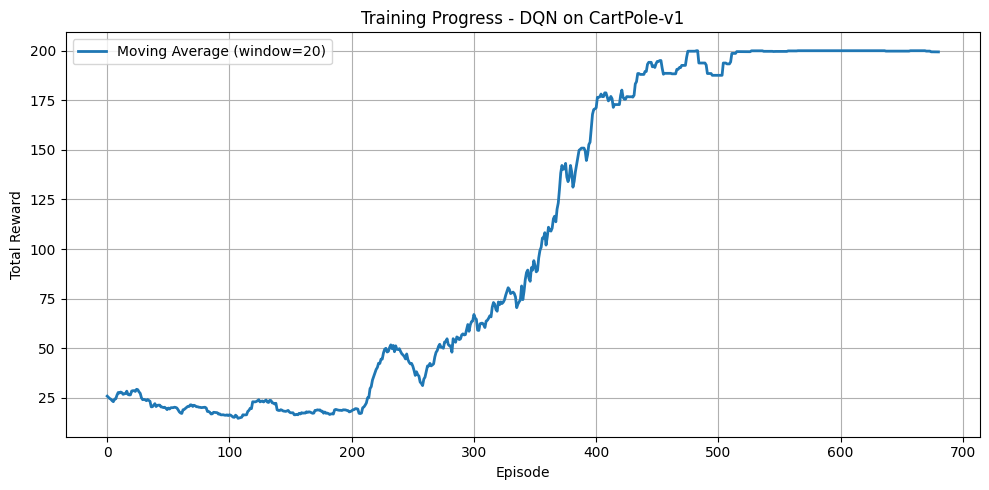


Final Success Rate: 38.57% (270 out of 700 episodes)


In [7]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

#-> Set up the environment
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

N = 700  #-----> Number of episodes
M = 0.0015 #Epsilon decay rate
X = 2 # Number of episodes to update the target network

#-> Training configuration
max_steps = 200
epsilon_start = 1.0
epsilon_end = 0.01
learning_rate = 0.00025
gamma = 0.99

#-> Initialize the DQN agent
agent = DQNAgent(state_size=state_dim, action_size=action_dim, seed=170715, lr=learning_rate)

# Track rewards and success
episode_rewards = []
success_count = 0

#-> Helper for moving average plot
def moving_average(data, window=20):
    return np.convolve(data, np.ones(window) / window, mode='valid')

# Main training loop
for episode in range(N):
    state, _ = env.reset()
    epsilon = max(epsilon_end, epsilon_start - M * episode)
    total_reward = 0

    for _ in range(max_steps):
        action = agent.act(state, eps=epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.step(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward
        if done:
            break

    episode_rewards.append(total_reward)

    if total_reward >= 195:
        success_count += 1

    # Logging progress
    if (episode + 1) % X == 0:
        agent.update_target() #---------> update the target network
        avg_reward = np.mean(episode_rewards[-100:])
        success_rate = (success_count / (episode + 1)) * 100
        print(f"Episode {episode + 1:>3} | Avg Reward (last 100): {avg_reward:.2f} | Success Rate: {success_rate:.1f}%")

# Plotting rewards over time
plt.figure(figsize=(10, 5))
plt.plot(moving_average(episode_rewards), label="Moving Average (window=20)", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress - DQN on CartPole-v1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final success summary
final_success_rate = (success_count / N) * 100
print(f"\nFinal Success Rate: {final_success_rate:.2f}% ({success_count} out of {N} episodes)")

Final success rate is %of episodes out of N episodes which gave avg reward value >=195



Here I've performed the hard update method which update the weights every X=2 steps,
to improve the model further we can include the feature of soft update instead which softly blends the new weights of target network to policy network